In [16]:
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

from IPython.display import display

import importlib
import glob
import time
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
import osmnx as ox
from src.data import processing_func

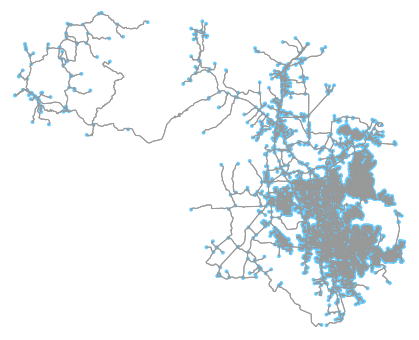

,highway,osmid,ref,x,y,geometry
274063877,NaN,274063877,NaN,-48.8163,-26.3918,POINT (-48.8162692 -26.3918219)
597508643,NaN,597508643,NaN,-49.2133,-26.1691,POINT (-49.2133184 -26.1691181)
597508666,NaN,597508666,NaN,-49.1707,-26.1875,POINT (-49.1707333 -26.1875192)
597509184,NaN,597509184,NaN,-49.0958,-26.2085,POINT (-49.0958145 -26.2084711)
601487382,NaN,601487382,NaN,-48.9031,-26.2873,POINT (-48.9030838 -26.2872981)


,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
0,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80799...",residential,NaN,0,NaN,32.577,NaN,Rua Mato Grosso do Sul,False,166708221,NaN,NaN,NaN,1781596160,2712030379,NaN
1,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80787...",residential,NaN,0,NaN,165.663,NaN,Rua Mato Grosso do Sul,False,166708221,NaN,NaN,NaN,1781596160,1781596141,NaN
2,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80763...",residential,NaN,0,NaN,34.044,NaN,Rua Vilmar da Silva,False,166708230,NaN,NaN,NaN,1781596160,4331763612,NaN
3,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80867...",residential,NaN,0,NaN,69.976,NaN,Rua Vilmar da Silva,False,166708230,NaN,NaN,NaN,1781596160,1808444244,NaN
4,NaN,NaN,"LINESTRING (-48.8083837 -26.3621753, -48.80847...",residential,NaN,0,NaN,163.247,NaN,Rua Espírito Santo,False,166708219,NaN,NaN,NaN,1781596162,1808444235,NaN


In [4]:
#Create Joinville polygon
joinville_polygon = "-48.802 -26.13,-48.883 -26.107,-49.161 -26.059,-49.224 -26.103,-49.239 -26.178,-49.245 -26.306,-49.043 -26.358,-48.923 -26.41,-48.898 -26.444,-48.858 -26.438,-48.802 -26.395,-48.727 -26.354,-48.746 -26.285,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13"
joinville_polygon = joinville_polygon.split(",")
joinville_polygon = [(float(coord.split(" ")[0]), float(coord.split(" ")[1])) for coord in joinville_polygon]
joinville_polygon = Polygon(joinville_polygon)

#Retrieve osm data from polygon
G = ox.graph_from_polygon(joinville_polygon, network_type='drive')
ox.plot_graph(G)

gdf_nodes, gdf_edges = ox.save_load.graph_to_gdfs(G)
display(gdf_nodes.head())
display(gdf_edges.head())

Get waze jams data:

In [21]:
#Connection and initial setup
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

meta = processing_func.connect_database(DATABASE)

geo_jams = processing_func.extract_geo_jams(meta, limit=1000)
geo_jams.head()

,id,uuid,pub_millis,pub_utc_date,start_node,end_node,road_type,street,city,country,...,blocking_alert_id,line,datafile_id,jams_line_list,jams_line_UTM,jam_LineString,jam_alt_LineString,LonDirection,LatDirection,MajorDirection
0,467e9d70cbf68f9172df3e60bd17f623ad350534,1705383785,1520933334455,2018-03-13 09:28:54.455,None,None,2,Av. Santos Dumont,Joinville,BR,...,6bad5f3f-52ff-3631-9d4f-ec072b4df260,"[{'x': -48.815729, 'y': -26.234097}, {'x': -48...",1305,"[(-48.815729, -26.234097), (-48.817753, -26.23...","[(718194.0993938535, 7096551.91303236), (71799...",POLYGON ((-48.81772623191966 -26.2346699590297...,"POLYGON ((717995.9731314245 7096482.114525973,...",Oeste,Sul,Leste/Oeste
1,940e2d3b89818cfb3ba9ade3b7b662af84de842d,1705383785,1520933334455,2018-03-13 09:28:54.455,None,None,2,Av. Santos Dumont,Joinville,BR,...,6bad5f3f-52ff-3631-9d4f-ec072b4df260,"[{'x': -48.815729, 'y': -26.234097}, {'x': -48...",1337,"[(-48.815729, -26.234097), (-48.817753, -26.23...","[(718194.0993938535, 7096551.91303236), (71799...",POLYGON ((-48.81772623191966 -26.2346699590297...,"POLYGON ((717995.9731314245 7096482.114525973,...",Oeste,Sul,Leste/Oeste
2,83567ffc07c82d3a94bb38decceeb88b1465c079,1705383785,1520933334455,2018-03-13 09:28:54.455,None,None,2,Av. Santos Dumont,Joinville,BR,...,6bad5f3f-52ff-3631-9d4f-ec072b4df260,"[{'x': -48.815729, 'y': -26.234097}, {'x': -48...",1285,"[(-48.815729, -26.234097), (-48.817753, -26.23...","[(718194.0993938535, 7096551.91303236), (71799...",POLYGON ((-48.81772623191966 -26.2346699590297...,"POLYGON ((717995.9731314245 7096482.114525973,...",Oeste,Sul,Leste/Oeste
3,fe740e6ede49ce063c91253affaeb29258d21986,1705383785,1520933334455,2018-03-13 09:28:54.455,None,None,2,Av. Santos Dumont,Joinville,BR,...,6bad5f3f-52ff-3631-9d4f-ec072b4df260,"[{'x': -48.815729, 'y': -26.234097}, {'x': -48...",1304,"[(-48.815729, -26.234097), (-48.817753, -26.23...","[(718194.0993938535, 7096551.91303236), (71799...",POLYGON ((-48.81772623191966 -26.2346699590297...,"POLYGON ((717995.9731314245 7096482.114525973,...",Oeste,Sul,Leste/Oeste
4,86564fd161239753118b14dbf79e6d116e1fdbe9,1705383785,1520933334455,2018-03-13 09:28:54.455,None,None,2,Av. Santos Dumont,Joinville,BR,...,6bad5f3f-52ff-3631-9d4f-ec072b4df260,"[{'x': -48.815729, 'y': -26.234097}, {'x': -48...",1321,"[(-48.815729, -26.234097), (-48.817753, -26.23...","[(718194.0993938535, 7096551.91303236), (71799...",POLYGON ((-48.81772623191966 -26.2346699590297...,"POLYGON ((717995.9731314245 7096482.114525973,...",Oeste,Sul,Leste/Oeste


Get internal GIS data:

In [25]:
importlib.reload(processing_func)
geo_sections = processing_func.extract_geo_sections(meta, main_buffer=10)
geo_sections.head()

,id,id_arcgis,street_code,street_name,cumulative_meters,length,linestring,max_x,max_y,min_x,min_y,street_direction,section_alt_polygon,section_direction,section_polygon
0,1,16092,2686,DR. JOAO COLIN,2335,89.0878,"(LINESTRING (714734.1111 7091467.602, 714740.5...",714740.5956,7.091468e+06,714734.1111,7.091379e+06,Norte/Sul,"POLYGON ((714760.5425490942 7091380.20625473, ...",Norte/Sul,POLYGON ((-48.84932169502329 -26.2812883957915...
1,2,16093,8937,SERVIDAO ARISTIDES FERREIRA,231,231.0090,"(LINESTRING (712587.072 7090233.5129, 712581.5...",712587.0720,7.090234e+06,712574.7055,7.090006e+06,Norte/Sul,"POLYGON ((712599.843260163 7090218.148389393, ...",Norte/Sul,POLYGON ((-48.87075707571263 -26.2920415133205...
2,3,16094,21426,SD 21426,92,91.8011,"(LINESTRING (711794.9619 7090331.3387, 711795....",711797.3378,7.090423e+06,711793.9437,7.090331e+06,Norte/Sul,"POLYGON ((711775.5056659706 7090337.567996975,...",Norte/Sul,POLYGON ((-48.87882904872053 -26.2911410854390...
3,4,16095,40087,GUILHERME BUCH PEREIRA,61,60.9810,"(LINESTRING (717162.3776 7083164.3607, 717169....",717169.0869,7.083225e+06,717162.3776,7.083164e+06,Norte/Sul,"POLYGON ((717149.208318668 7083227.171955459, ...",Norte/Sul,POLYGON ((-48.82383931748144 -26.3544925808141...
4,5,16096,40131,SERVIDAO ISRAEL JOAO RODRIGUES,84,84.0872,"(LINESTRING (716949.0882999999 7092081.4944, 7...",717006.8862,7.092143e+06,716949.0883,7.092081e+06,Norte/Sul,"POLYGON ((716992.3598014828 7092156.315735924,...",Norte/Sul,POLYGON ((-48.82694029160205 -26.2740018117055...


Merge three data sources

In [ ]:
# df_waze_sig = geo_sections.merge(df_jps, how="inner", on="SctnId")
# display(df_waze_sig.shape)
# display(df_waze_sig.head())

In [19]:
geo_sections.columns

Index(['SctnId', 'SctnIdArcgis', 'SctnCodRua', 'SctnDscNome',
       'SctnQtdMetrosAcumulados', 'SctnQtdComprimento',
       'SctnDscCoordxUtmComeco', 'SctnDscCoordyUtmComeco',
       'SctnDscCoordxUtmMeio', 'SctnDscCoordyUtmMeio', 'SctnDscCoordxUtmFinal',
       'SctnDscCoordyUtmFinal', 'MinX', 'MaxX', 'MinY', 'MaxY',
       'StreetDirection', 'SectionDirection', 'Street_line_XY',
       'Street_line_LonLat', 'section_LineString', 'section_alt_LineString'],
      dtype='object')

Get undirected Traffic Network

In [14]:
un_network = pd.read_csv(project_dir + "/data/external/od/Tabela_atributos_CSV.csv",
                         encoding="latin-1",
                         sep=";",
                         decimal=',')
un_network.head()
col_dict={'objectid,N,19,11': 'SctnIdArcgis',
            'codlogra,N,19,11': 'SctnCodRua',
            'acumulo,N,19,11': 'SctnQtdMetrosAcumulados',
            'nomelog,C,254': 'SctnDscNome',
            'x_ini,N,19,11': 'x_ini',
            'y_ini,N,19,11': 'y_ini',
            'x_med,N,19,11': 'x_med',
            'y_med,N,19,11': 'y_med',
            'x_fim,N,19,11': 'x_fim',
            'y_fim,N,19,11': 'y_fim',
         }
un_network.rename(columns=col_dict, inplace=True)
un_network = un_network[list(col_dict.values())]
un_network.drop_duplicates(["SctnCodRua", "SctnQtdMetrosAcumulados"], inplace=True)
un_network.set_index(["SctnCodRua", "SctnQtdMetrosAcumulados"], inplace=True, verify_integrity=True)
un_network = un_network.astype(int, errors='ignore')
un_network["initial_node"] = list(zip(un_network.x_ini, un_network.y_ini))
un_network["final_node"] = list(zip(un_network.x_fim, un_network.y_fim))
un_network.sample(5)

,,SctnIdArcgis,SctnDscNome,x_ini,y_ini,x_med,y_med,x_fim,y_fim,initial_node,final_node
SctnCodRua,SctnQtdMetrosAcumulados,,,,,,,,,,
1788.0,838.0,19339,COPACABANA,713872,7086107,713884,7085972,713814,7085849,"(713872, 7086107)","(713814, 7085849)"
8274.0,4770.0,25555,QUINZE DE NOVEMBRO,711213,7089782,711254,7089770,711296,7089757,"(711213, 7089782)","(711296, 7089757)"
4047.0,859.0,17237,GRACILIANO RAMOS,716722,7087433,716749,7087423,716755,7087395,"(716722, 7087433)","(716755, 7087395)"
8664.0,27.0,30823,SANTO AGOSTINHO,716754,7087360,716741,7087362,716728,7087359,"(716754, 7087360)","(716728, 7087359)"
1252.0,27844.0,0,GOVERNADOR MARIO COVAS,713711,7081880,713676,7082038,713642,7082196,"(713711, 7081880)","(713642, 7082196)"


Get number of directions per section

In [41]:
def get_two_ways(row):
    if row["SectionDirection"] == "Norte/Sul":
        if row["LatDirection"] == 2:
            return "two_way"
    
    if row["SectionDirection"] == "Leste/Oeste":
        if row["LonDirection"] == 2:
            return "two_way"
        
    return "unknown"

df_waze_directions = df_waze_sig.groupby(["SctnCodRua",
                                          "SctnQtdMetrosAcumulados",
                                          "SctnDscNome",
                                          "SectionDirection",
                                          "SctnDscCoordxUtmComeco",
                                          "SctnDscCoordyUtmComeco",
                                          "SctnDscCoordxUtmFinal",
                                          "SctnDscCoordyUtmFinal"]).agg({"LatDirection": pd.Series.nunique,
                                                                           "LonDirection": pd.Series.nunique
                                                                          })
df_waze_directions["total_directions"] = df_waze_directions["LatDirection"] + df_waze_directions["LonDirection"]
df_waze_directions.reset_index(inplace=True)
df_waze_directions["way"] = df_waze_directions.apply(get_two_ways, axis=1)
df_waze_directions.drop_duplicates(subset=["SctnCodRua", "SctnQtdMetrosAcumulados"], inplace=True)
df_waze_directions.set_index(["SctnCodRua", "SctnQtdMetrosAcumulados"], inplace=True, verify_integrity=True)
df_waze_directions.sort_values("total_directions", ascending=False, inplace=True)
df_waze_directions.head()

SctnDscNome SectionDirection  \
SctnCodRua SctnQtdMetrosAcumulados                                          
2691       380                      DOUTOR PLACIDO GOMES      Leste/Oeste   
8274       4410                       QUINZE DE NOVEMBRO        Norte/Sul   
3497       324                                   ESPIGAO        Norte/Sul   
           400                                   ESPIGAO        Norte/Sul   
3505       2149                                 BARBANTE        Norte/Sul   

                                    SctnDscCoordxUtmComeco  \
SctnCodRua SctnQtdMetrosAcumulados                           
2691       380                                 714960.2945   
8274       4410                                711545.2532   
3497       324                                 720725.6297   
           400                                 720690.8223   
3505       2149                                708208.3280   

                                    SctnDscCoordyUtmComeco  \
SctnCodRua SctnQtdMetrosAcumulados                           
2691       380                                7.088144e+06   
8274       4410                               7.089831e+06   
3497       324                                7.084441e+06   
           400                                7.084508e+06   
3505       2149                               7.087394e+06   

                                    SctnDscCoordxUtmFinal  \
SctnCodRua SctnQtdMetrosAcumulados                          
2691       380                                715074.0814   
8274       4410                               711601.0300   
3497       324                                720740.2162   
           400                                720725.6297   
3505       2149                               707425.4000   

                                    SctnDscCoordyUtmFinal  LatDirection  \
SctnCodRua SctnQtdMetrosAcumulados                                        
2691       380                               7.088149e+06             2   
8274       4410                              7.089977e+06             2   
3497       324                               7.084416e+06             2   
           400                               7.084441e+06             2   
3505       2149                              7.088275e+06             2   

                                    LonDirection  total_directions      way  
SctnCodRua SctnQtdMetrosAcumulados                                           
2691       380                                 2                 4  two_way  
8274       4410                                2                 4  two_way  
3497       324                                 2                 4  two_way  
           400                                 2                 4  two_way  
3505       2149                                2                 4  two_way

Cross-checking classification:

In [93]:
directions_gb = df_waze_directions.groupby(["SctnDscNome", "way"]).agg({"way": "count"}).sort_values("way",
                                                                                     ascending=False)
directions_gb.xs("two_way", level="way", drop_level=False)
directions_gb.to_csv(project_dir + "/data/interim/od/check_sentidos.csv")

Generate traffic network duplicating two-way streets. To achieve that we will assume that any street that contains AT LEAST ONE two-way section is two-way in its entirety.

In [49]:
un_network_join = un_network.join(df_waze_directions["way"])
un_network_join.groupby("SctnDscNome").agg(lambda x: "two_way" in x["way"])
un_network


SctnIdArcgis  \
SctnCodRua SctnQtdMetrosAcumulados                 
2686.0     2335.0                          16092   
           2246.0                          16124   
6239.0     3115.0                          16126   
2686.0     2144.0                          16136   
           1978.0                          16137   
6239.0     6268.0                          16141   
3723.0     2933.0                          16161   
2686.0     1928.0                          16163   
8655.0     103.0                           16180   
2686.0     1861.0                          16183   
           1671.0                          16185   
           1403.0                          16187   
4057.0     3301.0                          16192   
2686.0     1284.0                          16194   
2650.0     2031.0                          16197   
9254.0     1386.0                          16202   
2686.0     1179.0                          16216   
           2567.0                          16226   
6239.0     3116.0                          16260   
3382.0     1311.0                          16275   
8690.0     3866.0                          16297   
3382.0     1802.0                          16320   
6239.0     2299.0                          16332   
           2280.0                          16336   
304.0      105.0                           16330   
8277.0     2015.0                          16347   
2650.0     7152.0                          16375   
9954.0     268.0                           16389   
2650.0     7099.0                          16397   
           7143.0                          16398   
...                                          ...   
6947.0     227.0                               0   
1713.0     152.0                               0   
           218.0                               0   
           40.0                                0   
           359.0                               0   
           130.0                               0   
6947.0     930.0                               0   
           617.0                               0   
1713.0     21.0                                0   
           516.0                               0   
6947.0     422.0                               0   
9982.0     169.0                               0   
           89.0                                0   
56.0       2214.0                              0   
           2278.0                              0   
           2091.0                              0   
           2153.0                              0   
7353.0     47.0                                0   
           38.0                                0   
9756.0     188.0                               0   
551.0      672.0                               0   
1252.0     9010.0                              0   
           1924.0                              0   
           3722.0                              0   
           1444.0                              0   
           3291.0                              0   
           4563.0                              0   
           2244.0                              0   
           1430.0                              0   
           958.0                               0   

                                                     SctnDscNome   x_ini  \
SctnCodRua SctnQtdMetrosAcumulados                                         
2686.0     2335.0                                 DR. JOAO COLIN  714734   
           2246.0                                 DR. JOAO COLIN  714740   
6239.0     3115.0                              MONSENHOR GERCINO  717054   
2686.0     2144.0                                 DR. JOAO COLIN  714747   
           1978.0                                 DR. JOAO COLIN  714759   
6239.0     6268.0                              MONSENHOR GERCINO  719910   
3723.0     2933.0                                  FLORIANOPOLIS  717884   
2686.0     1928.0                                 DR. JOAO COLIN  714764   